In [ ]:
import sys
import os

# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

# Libraries for causal inference
from causalinference import CausalModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dowhy
import networkx as nx
from graphviz import Digraph
from econml.dml import LinearDML, CausalForestDML
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Get the absolute path of the subfolder
term_deposit_path = os.path.abspath(os.path.join('..', 'term-deposit'))

# Add the path to the sys.path list
sys.path.append(term_deposit_path)


import causal_analysis as ca


# Load the dataset
data_encoded = pd.read_parquet('../data/data_precall_encoded.parquet')


display(data_encoded.describe())

# Display the first few rows of the dataset
display(data_encoded.head())

display(data_encoded.info())

: 

**Observations**

- The dataset includes various features such as `age`, `job`, `marital status`, `education`, `default`, `balance`, `housing`, `loan`, `contact type`, `day`, `month`, `duration`, `campaign`, and the target variable `y` (whether the customer subscribed to a term deposit).
- Some columns, like `contact`, have a value of "unknown", indicating missing data.

##  1. Define the Causal Question
1. What are the causal effects of customer characteristics and marketing strategies on the likelihood of a customer subscribing to a term deposit
2. How can we identify and target the ideal customer profiles to enhance the success rate of marketing campaigns?

## **2. Construct a Causal Model**

- Directed Acyclic Graph (DAG):

   Create a DAG to represent assumptions about causal relationships between variables.

  - **Nodes:** Variables in your dataset.
  - **Edges:** Arrows indicating the direction of causality.

- **Identify Confounders:** Variables that affect both the predictor and the outcome (e.g., age may influence both job type and sign-up likelihood).

#### **Assumed Causal Relationships**

Below is a textual description of the DAG, outlining the assumed causal pathways between variables:

1. **Demographic Factors Influence Financial Status:**
   - **Age**, **Job Type**, **Education Level**, and **Marital Status** affect the **Financial Indicators** such as `high_balance`, `default_yes`, `housing_yes`, and `loan_yes`.
     - For example, older customers (`age_group_60+`) might have higher account balances (`high_balance`) due to accumulated savings.

2. **Demographic and Financial Factors Influence Marketing Success:**
   - **Demographics** and **Financial Indicators** directly influence the **Likelihood of Subscription (`y`)**.
     - Customers with higher balances might be more likely to invest in term deposits.
     - Educational level may affect financial literacy and openness to financial products.

3. **Marketing Interaction Affects Likelihood of Subscription:**
   - The **Contact Method (`contact_telephone`)** directly influences **`y`**.
     - The effectiveness of different contact methods can vary across customer segments.

4. **Propensity Score as a Summary of Observed Characteristics:**
   - The **`propensity_score`** is influenced by all observed characteristics and summarizes the probability of a customer subscribing based on these features.

5. **Interaction Terms Capture Combined Effects:**
   - **Interaction Terms** like `age_balance_interaction` represent the combined causal effect of age and balance on the likelihood of subscription.
     - These terms help in modeling the synergistic effects that wouldn't be captured by individual variables alone.

6. **Potential Confounders:**
   - **Unobserved Factors**: There may be unmeasured variables (e.g., risk tolerance, financial literacy) that influence both the predictors and the outcome.

#### **Textual Representation of the DAG**

Let's describe the DAG layers and the causal links.

1. **First Layer (Exogenous Variables):**
   - **Demographics:** `age_group_18-30`, `age_group_60+`, `job_*`, `marital_*`, `education_*`
   - These are the starting points in the DAG as they are not caused by other variables in our model.

2. **Second Layer (Mediating Variables):**
   - **Financial Indicators:** `high_balance`, `default_yes`, `housing_yes`, `loan_yes`
   - **Interaction Terms:** `age_balance_interaction`, `married_high_balance`, etc.
   - **Propensity Score:** `propensity_score`
   - Demographic variables influence these mediators.

3. **Third Layer (Outcome Variable):**
   - **`y`**: Subscription to a term deposit.
   - Influenced by Demographics, Financial Indicators, Interaction Terms, and Marketing Interaction.

#### **Causal Paths**

1. **From Demographics to Outcome:**
   - **Direct Paths:** Demographics ➔ `y`
     - E.g., `age_group_60+` ➔ `y`
   - **Indirect Paths:** Demographics ➔ Financial Indicators ➔ `y`
     - E.g., `education_tertiary` ➔ `high_balance` ➔ `y`

2. **From Financial Indicators to Outcome:**
   - **Direct Paths:** Financial Indicators ➔ `y`
     - E.g., `high_balance` ➔ `y`

3. **From Marketing Interaction to Outcome:**
   - **Direct Path:** `contact_telephone` ➔ `y`
     - The method of contact may directly affect the likelihood of subscription.

4. **From Interaction Terms to Outcome:**
   - **Direct Paths:** Interaction Terms ➔ `y`
     - E.g., `married_high_balance` ➔ `y`

5. **From Propensity Score to Outcome:**
   - **Direct Path:** `propensity_score` ➔ `y`
     - This score summarizes the estimated likelihood of subscription based on observed features.

#### 

Let's analyze the effect of high_balance

In [4]:
confounders = [
    'age_group_60+', 'education_tertiary', 'job_blue-collar',
    'job_student', 'loan_yes', 'housing_yes', 'marital_married'
]

treatment = 'high_balance'
outcome = 'y'

In [ ]:
causal_model_ci = ca.causalinference_analysis(
    data_encoded,
    treatment,
    outcome,
    confounders
    )

In [ ]:
causal_model_dw = ca.dowhy_analysis(
    data_encoded,
    treatment,
    outcome,
    confounders
    )

In [ ]:
import causal_analysis as ca

causal_model_rt = ca.refutation_test(
    data_encoded,
    causal_model_ci,
    treatment,
    outcome,
    confounders
    )

NameError: name 'causal_model_ci' is not defined

In [ ]:
causal_model_sa = ca.sensitivity_analysis(
    data_encoded,
    causal_model_ci,
    treatment,
    outcome,
    confounders
    )

## 3 Choose a Causal Inference Method

**Regression Analysis:**

- **Logistic Regression:** Model the probability of sign-up as a function of predictor variables.
- **Include Interaction Terms:** To capture combined effects.
- **Adjust for Confounders:** Include confounding variables in your model to isolate the causal effect.

**Propensity Score Methods:**

- **Matching:** Match customers with similar propensity scores but different exposure to a treatment (e.g., being in a particular age group).
- **Weighting:** Weight observations by the inverse probability of treatment to create a pseudo-population where the treatment is independent of confounders.

**Instrumental Variables (IV):**

- **When Applicable:** Use if there's a variable that affects the treatment but not the outcome directly.

**Causal Machine Learning Models:**

- **Causal Forests:** Can estimate heterogeneous treatment effects.

### 3.1 Regression Models

In [25]:
# Define the treatment variables and confounders
X = data_encoded[['age_group_18-30', 'age_group_60+',
                #   'duration_q1', 'duration_q2', 'duration_q3',
                  'education_tertiary', 'education_secondary',
                  'job_blue-collar', 'job_entrepreneur', 
                  'job_housemaid', 'job_retired', 'job_self-employed', 
                  'job_services', 'job_student', 'job_technician', 'job_unemployed',
                  'housing_yes', 'loan_yes', 'high_balance', 'marital_married']]

# Add an intercept to the model
X = sm.add_constant(X)

# Outcome variable
y = data_encoded['y']

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.251237
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39982
Method:                           MLE   Df Model:                           17
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03297
Time:                        14:11:27   Log-Likelihood:                -10049.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                1.159e-134
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5345      0.077    -32.934      0.000      -2.685      -2.384
ag

In [26]:
# Interaction terms
data_encoded['age_balance_interaction'] = data_encoded['age_group_60+'] * data_encoded['high_balance']
data_encoded['young_single_tertiary'] = data_encoded['age_group_18-30'] * data_encoded['education_tertiary'] * (1 - data_encoded['marital_married'])
# data_encoded['long_duration_retired'] = data_encoded['duration_q2'] * data_encoded['job_retired']
data_encoded['married_high_balance'] = data_encoded['marital_married'] * data_encoded['high_balance']

# Define the model with interaction terms
X = data_encoded[['age_group_18-30', 'age_group_60+', 
                #   'duration_q1', 'duration_q2', 'duration_q3','long_duration_retired',
                  'education_tertiary', 'education_secondary',
                  'job_blue-collar', 'job_entrepreneur', 
                  'job_housemaid', 'job_retired', 'job_self-employed', 
                  'job_services', 'job_student', 'job_technician', 'job_unemployed',
                  'housing_yes', 'loan_yes', 'high_balance', 'marital_married',
                  'age_balance_interaction', 'young_single_tertiary',
                   'married_high_balance']]

# Add a constant
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(data_encoded['y'], X)
result = logit_model.fit()

# Output the model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.251228
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39979
Method:                           MLE   Df Model:                           20
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03301
Time:                        14:11:27   Log-Likelihood:                -10049.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                1.997e-132
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.5355      0.079    -32.052      0.000      -2.691   

Remove non-significant interaction terms and keep significant ones

In [27]:
# Retain significant main effects and interaction terms
X_simplified = data_encoded[['age_group_18-30', 'age_group_60+', 
                            #  'duration_short', 'duration_medium', 'duration_long', 'long_duration_retired',
                             'education_tertiary', 'job_blue-collar', 'job_student',
                             'housing_yes', 'loan_yes', 'high_balance', 'marital_married',
                             ]]

# Add a constant
X_simplified = sm.add_constant(X_simplified)

# Refit the logistic regression model with the simplified terms
logit_model_simplified = sm.Logit(data_encoded['y'], X_simplified)
result_simplified = logit_model_simplified.fit()

# Output the model summary
print(result_simplified.summary())

Optimization terminated successfully.
         Current function value: 0.251501
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39990
Method:                           MLE   Df Model:                            9
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03195
Time:                        14:11:27   Log-Likelihood:                -10060.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                3.525e-137
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4618      0.048    -50.900      0.000      -2.557      -2.367
age_g

New Hypothesis Interaction Terms

In [28]:
# New Hypothesis Interaction Terms
data_encoded['age_tertiary_interaction'] = data_encoded['age_group_60+'] * data_encoded['education_tertiary']
data_encoded['student_high_balance'] = data_encoded['job_student'] * data_encoded['high_balance']
data_encoded['retired_high_balance'] = data_encoded['job_retired'] * data_encoded['high_balance']
# data_encoded['long_duration_bluecollar'] = data_encoded['duration_long'] * data_encoded['job_blue-collar']

# Define the model with new interaction terms
X_new_hypotheses = data_encoded[['age_group_18-30', 'age_group_60+', 
                                #  , 'long_duration_bluecollar''duration_short', 'duration_medium', 'duration_long',
                                 'education_tertiary', 'job_blue-collar', 'job_student', 
                                 'housing_yes', 'loan_yes', 'high_balance', 'marital_married',
                                 'age_tertiary_interaction', 'student_high_balance', 
                                 'retired_high_balance']]

# Add a constant
X_new_hypotheses = sm.add_constant(X_new_hypotheses)

# Fit the logistic regression model with the new interaction terms
logit_model_new_hypotheses = sm.Logit(data_encoded['y'], X_new_hypotheses)
result_new_hypotheses = logit_model_new_hypotheses.fit(maxiter=1000)

# Output the model summary
print(result_new_hypotheses.summary())

Optimization terminated successfully.
         Current function value: 0.251456
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39987
Method:                           MLE   Df Model:                           12
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03213
Time:                        14:11:27   Log-Likelihood:                -10058.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                3.465e-135
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4680      0.049    -50.763      0.000      -2.563

Simplify the model

In [29]:
# Retain the current set of variables and interactions
X_adjusted = data_encoded[['age_group_18-30', 'age_group_60+', 
                        #    'duration_short', 'duration_medium', 'duration_long',
                           'education_tertiary', 'job_blue-collar', 'job_student', 
                           'housing_yes', 'loan_yes', 'high_balance', 'marital_married',
                        #    'age_tertiary_interaction', 'student_high_balance', 
                           'retired_high_balance',
                        #    'long_duration_bluecollar'
                           ]]

# Add a constant
X_adjusted = sm.add_constant(X_adjusted)

# Fit the logistic regression model with increased iterations and a different solver
logit_model_adjusted = sm.Logit(data_encoded['y'], X_adjusted)
result_adjusted = logit_model_adjusted.fit(method='bfgs', maxiter=2000)

# Output the model summary
print(result_adjusted.summary())


Optimization terminated successfully.
         Current function value: 0.251490
         Iterations: 88
         Function evaluations: 89
         Gradient evaluations: 89
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39989
Method:                           MLE   Df Model:                           10
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03200
Time:                        14:11:28   Log-Likelihood:                -10060.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                1.970e-136
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const             

Removing less theoretically justified interactions

In [30]:
# Simplify by removing less theoretically justified interactions
X_simplified_further = data_encoded[['age_group_18-30', 'age_group_60+', 
                                    #  'duration_short', 'duration_medium', 'duration_long',
                                     'education_tertiary', 'job_blue-collar', 'job_student', 
                                     'housing_yes', 'loan_yes', 'high_balance', 'marital_married',
                                    #  'long_duration_bluecollar'
                                     ]]  # Keep the most relevant interaction

# Add a constant
X_simplified_further = sm.add_constant(X_simplified_further)

# Fit the logistic regression model with the simplified interaction terms
logit_model_simplified_further = sm.Logit(data_encoded['y'], X_simplified_further)
result_simplified_further = logit_model_simplified_further.fit(method='bfgs', maxiter=2000)

# Output the model summary
print(result_simplified_further.summary())

Optimization terminated successfully.
         Current function value: 0.251501
         Iterations: 76
         Function evaluations: 77
         Gradient evaluations: 77
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39990
Method:                           MLE   Df Model:                            9
Date:                Sat, 21 Sep 2024   Pseudo R-squ.:                 0.03195
Time:                        14:11:28   Log-Likelihood:                -10060.
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                3.527e-137
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 

In [31]:
# Standardize the features to improve the stability of regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

# Apply L2 regularization (Ridge)
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000)
model_l2.fit(X_scaled, data_encoded['y'])

# Get the coefficients and interpret the results
coefficients = pd.DataFrame({'Feature': X_adjusted.columns, 'Coefficient': model_l2.coef_[0]})
print(coefficients.sort_values("Coefficient", ascending=False))

                 Feature  Coefficient
8           high_balance     0.181253
2          age_group_60+     0.150368
1        age_group_18-30     0.144983
3     education_tertiary     0.117685
5            job_student     0.042411
10  retired_high_balance     0.016715
0                  const     0.000000
4        job_blue-collar    -0.020853
7               loan_yes    -0.094737
6            housing_yes    -0.167260
9        marital_married    -0.172249



### 3.2 Propensity Score Matching (PSM)

In [32]:
# Calculate confidence intervals for the simplified model
result_simplified = sm.Logit(data_encoded['y'], X_adjusted).fit()
conf_int = result_simplified.conf_int()
conf_int['OR'] = result_simplified.params
conf_int.columns = ['2.5%', '97.5%', 'OR']
print(conf_int)

# Sensitivity analysis would require additional methods like E-values or Rosenbaum bounds
# Here, we'll focus on robust standard errors as a basic sensitivity analysis approach
result_simplified_robust = sm.Logit(data_encoded['y'], X_adjusted).fit(cov_type='HC3')
print(result_simplified_robust.summary())

Optimization terminated successfully.
         Current function value: 0.251490
         Iterations 7
                          2.5%     97.5%        OR
const                -2.558456 -2.368661 -2.463558
age_group_18-30       0.308656  0.513426  0.411041
age_group_60+         1.678974  2.266305  1.972639
education_tertiary    0.176221  0.348438  0.262330
job_blue-collar      -0.154826  0.056386 -0.049220
job_student           0.121571  0.624495  0.373033
housing_yes          -0.420396 -0.263491 -0.341943
loan_yes             -0.363327 -0.137993 -0.250660
high_balance          0.292340  0.449155  0.370748
marital_married      -0.434336 -0.272688 -0.353512
retired_high_balance -0.132602  0.395718  0.131558
Optimization terminated successfully.
         Current function value: 0.251490
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                    

In [33]:
# Step 1: Estimate propensity scores
confounders = ['age_group_60+', 'age_group_18-30', 'education_tertiary',
               'job_student', 'job_blue-collar', 'loan_yes', 'housing_yes', 'marital_married']

# Logistic regression to estimate propensity scores
logistic_model = LogisticRegression()
logistic_model.fit(data_encoded[confounders], data_encoded['high_balance'])

# Propensity scores
data_encoded['propensity_score'] = logistic_model.predict_proba(data_encoded[confounders])[:,1]

# Step 2: Matching based on propensity scores
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(data_encoded[['propensity_score']])
distances, indices = nbrs.kneighbors(data_encoded[['propensity_score']])

# Create a matched dataset
matched_data = data_encoded.iloc[indices.flatten()].copy()

# Step 3: Estimate ATE for high balance
treated = matched_data[matched_data['high_balance'] == 1]['y']
control = matched_data[matched_data['high_balance'] == 0]['y']

ATE = treated.mean() - control.mean()
print(f"Estimated ATE: {ATE}")

# Confidence intervals for the ATE
conf_interval = np.percentile([ATE], [2.5, 97.5])
print(f"Confidence Interval for ATE: {conf_interval}")

Estimated ATE: 0.07010478197033689
Confidence Interval for ATE: [0.07010478 0.07010478]


## 4. Estimate Causal Effects

- **Average Treatment Effect (ATE)**: The average effect of a treatment (e.g., being married) on the outcome across all individuals.
- **Conditional Average Treatment Effect (CATE)**: The effect of the treatment on subgroups (e.g., age groups).
- **Interpret Coefficients**: In logistic regression, exponentiate coefficients to get odds ratios.

### 4.1 Average threatment effect

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[y|housing_yes,education_tertiary,job_blue-collar,loan_yes,ma ↪
d[high_balance]                                                                ↪

↪                                          
↪ rital_married,age_group_60+,job_student])
↪                                          
Estimand assumption 1, Unconfoundedness: If U→{high_balance} and U→y then P(y|high_balance,housing_yes,education_tertiary,job_blue-collar,loan_yes,marital_married,age_group_60+,job_student,U) = P(y|high_balance,housing_yes,education_tertiary,job_blue-collar,loan_yes,marital_married,age_group_60+,job_student)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: Estimand

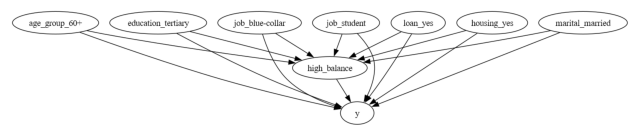

In [89]:
# Identify causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

# Estimate the causal effect using a linear regression method
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")
print(causal_estimate)

# View the results
model.view_model(layout="dot")

In [93]:
# Perform a sensitivity analysis
m = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
{"estimated_effect":m.estimated_effect,
"refutation_result":m.refutation_result}

## Explore Nonlinear Relationships
Using a Random Forest to Detect Nonlinear Effects

We can fit a random forest to see if there are any nonlinear relationships between the variables and the outcome.

> **Interpret Feature Importance**: This will help you see which variables are most important in predicting the outcome and whether the relationships are likely linear or nonlinear.

In [90]:
# Define the model with EconML
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)

# Fit the model
est.fit(Y=data_encoded[outcome], T=data_encoded[treatment], X=data_encoded[confounders])

# Estimate the treatment effect
treatment_effect = est.effect(data_encoded[confounders])
print("Estimated Treatment Effect:", treatment_effect.mean())

# Confidence Interval
intervals = est.effect_interval(data_encoded[confounders])
print("95% Confidence Interval:", intervals)

Estimated Treatment Effect: 0.028672142056729102
95% Confidence Interval: (array([ 0.03944093,  0.02198849, -0.00986797, ...,  0.03944093,
        0.03093272,  0.0050218 ]), array([0.07478561, 0.05937839, 0.0364616 , ..., 0.07478561, 0.06414668,
       0.03259764]))


### Check for Multicollinearity

**Interpret VIF**: If VIF values are above 5-10, consider removing or combining variables to reduce multicollinearity.

In [103]:
# Assuming data_encoded is your DataFrame with relevant variables
variables = ['age_group_60+', 'high_balance', 'education_tertiary', 
             'job_blue-collar', 'job_student', 'loan_yes', 
             'housing_yes', 'marital_married']

X = data_encoded[variables]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

              feature       VIF
0       age_group_60+  1.016061
1        high_balance  1.526336
2  education_tertiary  1.387082
3     job_blue-collar  1.370046
4         job_student  1.012008
5            loan_yes  1.173283
6         housing_yes  1.784662
7     marital_married  1.934485


In [33]:
# Fit a Random Forest model to explore nonlinear relationships
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, data_encoded['y'])

# Evaluate the model
roc_auc = roc_auc_score(data_encoded['y'], rf_model.predict_proba(X)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

# Check feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

ROC AUC Score: 0.8709871707344313
                    feature  importance
5             duration_long    0.232671
3            duration_short    0.121273
4           duration_medium    0.076357
17              housing_yes    0.063850
18                 loan_yes    0.047352
19             high_balance    0.044044
2             age_group_60+    0.040990
7       education_secondary    0.040300
1           age_group_18-30    0.038436
20          marital_married    0.036790
6        education_tertiary    0.033514
15           job_technician    0.026568
12        job_self-employed    0.023837
8           job_blue-collar    0.023541
14              job_student    0.021222
13             job_services    0.021036
9          job_entrepreneur    0.018365
16           job_unemployed    0.016380
10            job_housemaid    0.015940
21  age_balance_interaction    0.014490
24     married_high_balance    0.013668
11              job_retired    0.011784
22    young_single_tertiary    0.009143
23    

### Estimating Heterogeneous Effects Using Causal Forests

We can use the CausalForestDML from EconML to estimate HTEs. This method allows us to understand how the effect of high_balance varies across different subgroups defined by features like age, education, job type, etc.

In [34]:
model = CausalModel(
    data=data_encoded,
    treatment='high_balance',
    outcome='y',
    common_causes=['age_group_60+', 'education_tertiary', 'job_blue-collar', 
                   'job_student', 'loan_yes', 'housing_yes', 'marital_married']
)

# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")
print(causal_estimate)

TypeError: CausalModel.__init__() got an unexpected keyword argument 'data'

In [119]:
# Step 1: Create the causal graph using networkx
G = nx.DiGraph()

# Add edges representing the causal relationships
G.add_edges_from([
    ("high_balance", "y"),
    ("housing_yes", "y"),
    ("education_tertiary", "y"),
    ("loan_yes", "y"),
    ("marital_married", "y"),
    ("age_group_60+", "y"),
    ("job_student", "y"),
    ("age_group_60+", "high_balance"),
    ("marital_married", "high_balance"),
    ("education_tertiary", "high_balance")
])

# Step 2: Create the CausalModel using the networkx DiGraph
model = CausalModel(
    data=data_encoded,
    treatment='high_balance',
    outcome='y',
    graph=G  # Passing the networkx graph directly
)

# Step 3: Identify and estimate the causal effect
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                              
───────────────(E[y|education_tertiary,marital_married,age_group_60+])
d[high_balance]                                                       
Estimand assumption 1, Unconfoundedness: If U→{high_balance} and U→y then P(y|high_balance,education_tertiary,marital_married,age_group_60+,U) = P(y|high_balance,education_tertiary,marital_married,age_group_60+)

## Realized estimand
b: y~high_balance+education_tertiary+marital_married+age_group_60++high_balance*loan_yes+high_balance*job_student+high_balance*housing_yes
Target units: 

## Estimate
Mean value: 0.029640922415299184
### Conditional Estimates
__categorical__loan_yes  __categorical__job_student  __categorical__housing_yes
(-0.001, 1.0]            (-0.001, 1.0]               (-0.001, 1.0]                 0.02964

In [120]:
# Create an expanded causal graph using networkx
G = nx.DiGraph()

# Add edges representing the causal relationships
G.add_edges_from([
    ("high_balance", "y"),
    ("housing_yes", "y"),
    ("education_tertiary", "y"),
    ("loan_yes", "y"),
    ("marital_married", "y"),
    ("age_group_60+", "y"),
    ("job_student", "y"),
    ("job_blue-collar", "y"),
    ("education_secondary", "y"),
    ("default_yes", "y"),
    ("age_group_60+", "high_balance"),
    ("marital_married", "high_balance"),
    ("education_tertiary", "high_balance"),
    ("job_blue-collar", "high_balance"),
    ("default_yes", "high_balance")
])

# Create the CausalModel using the networkx DiGraph
model = CausalModel(
    data=data_encoded,
    treatment='high_balance',
    outcome='y',
    graph=G  # Passing the expanded networkx graph
)

# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[y|age_group_60+,job_blue-collar,marital_married,default_yes, ↪
d[high_balance]                                                                ↪

↪                     
↪ education_tertiary])
↪                     
Estimand assumption 1, Unconfoundedness: If U→{high_balance} and U→y then P(y|high_balance,age_group_60+,job_blue-collar,marital_married,default_yes,education_tertiary,U) = P(y|high_balance,age_group_60+,job_blue-collar,marital_married,default_yes,education_tertiary)

## Realized estimand
b: y~high_balance+age_group_60++job_blue-collar+marital_married+default_yes+education_tertiary+high_balance*loan_yes+high_balance*education_secondary+high_balance*housing_yes+high_balance*job_student
Target units: 

## Estimate
Mean value: 

In [36]:
def test_treatment_effect(data, treatment_var, outcome_var, features, heterogeneous_effects=False):
    """
    Test the causal effect of a treatment variable on an outcome variable.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing all the relevant variables.
    - treatment_var (str): The name of the treatment variable.
    - outcome_var (str): The name of the outcome variable.
    - features (list of str): The list of covariates to adjust for.
    - heterogeneous_effects (bool): Whether to calculate and print heterogeneous effects.
    
    Returns:
    - Estimated Treatment Effect (float)
    - Heterogeneous Treatment Effects (pd.DataFrame) if heterogeneous_effects=True, else None.
    """
    
    # Define the Causal Forest model
    est = CausalForestDML(
        model_y=RandomForestRegressor(),
        model_t=RandomForestRegressor(),
        random_state=123
    )
    
    # Fit the model using the specified treatment variable
    est.fit(
        Y=data[outcome_var], 
        T=data[treatment_var], 
        X=data[features]
    )
    
    # Estimate the treatment effect
    treatment_effect = np.mean(est.effect(data[features]))
    print(f"Estimated Treatment Effect for {treatment_var}: {treatment_effect}")
    
    # Confidence Interval
    intervals = est.effect_interval(data[features])
    print(f"95% Confidence Interval for {treatment_var}: {intervals}")
    
    heterogeneous_effects_df = None
    
    if heterogeneous_effects:
        display(Markdown("\n#### Heterogeneous Treatment Effects by Subgroup:"))
        effects = {}
        
        for feature in features:
            subgroup_effects = {}
            subgroups = data.groupby(feature)
            for group_name, group in subgroups:
                group_treatment_effect = np.mean(est.effect(group[features]))
                subgroup_effects[group_name] = group_treatment_effect
            
            effects[feature] = subgroup_effects
        
        # Convert to DataFrame
        heterogeneous_effects_df = pd.DataFrame(effects)
        display(heterogeneous_effects_df)
    
    return treatment_effect, heterogeneous_effects_df

#TODO: parallezilation here

In [ ]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define your treatment variables and functions
treatment_vars = list(set(data_encoded.columns) - {'y', 'propensity_score', 'long_duration_bluecollar',
                                                   'long_duration_retired', 'duration_medium', 'duration_short', 'duration_long'})

# Store results
ete_results = {}
hte_results = {}

# Function to process each treatment variable
def process_treatment(treatment):
    print(f"\nTesting treatment: {treatment}")
    selected_features = {'age_group_60+', 'high_balance', 'job_blue-collar',
                         'job_student', 'loan_yes', 'housing_yes', 'marital_married',
                         'education_secondary', 'default_yes'} - {treatment}
    
    ete, hte_df = test_treatment_effect(
        data=data_encoded,
        treatment_var=treatment,
        outcome_var='y',
        features=list(selected_features),
        heterogeneous_effects=True
    )
    
    return treatment, ete, hte_df

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    # Submit all tasks to the thread pool
    future_to_treatment = {executor.submit(process_treatment, treatment): treatment for treatment in treatment_vars}

    # As each task completes, store its results
    for future in as_completed(future_to_treatment):
        treatment = future_to_treatment[future]
        try:
            treatment, ete, hte_df = future.result()
            ete_results[treatment] = ete
            hte_results[treatment] = hte_df
        except Exception as e:
            print(f"Exception for treatment {treatment}: {e}")

# Convert the ETE results to a DataFrame for comparison
ete_df = pd.DataFrame(list(ete_results.items()), columns=['Treatment', 'Estimated Treatment Effect'])
print("\nEstimated Treatment Effects for Different Variables:")
print(ete_df)

# Display HTE results for one of the variables as an example
if 'education_tertiary' in hte_results:
    print("\nHeterogeneous Treatment Effects for 'education_tertiary':")
    print(hte_results['education_tertiary'])


In [37]:
# List of treatment variables to compare
treatment_vars= list(set(data_encoded.columns) - {'y','propensity_score', 'long_duration_bluecollar',
 'long_duration_retired','duration_medium', 'duration_short','duration_long'})

# Store results
ete_results = {}
hte_results = {}

# Loop through each treatment variable
for treatment in treatment_vars:
    print(f"\nTesting treatment: {treatment}")
    selected_features = {'age_group_60+', 'high_balance', 'job_blue-collar',
                         'job_student', 'loan_yes', 'housing_yes', 'marital_married',
                         'education_secondary', 'default_yes'} - {treatment}
    ete, hte_df = test_treatment_effect(
        data=data_encoded,
        treatment_var=treatment,
        outcome_var='y',
        features=list(selected_features),
        heterogeneous_effects=True
    )
    
    # Store the results
    ete_results[treatment] = ete
    hte_results[treatment] = hte_df

# Convert the ETE results to a DataFrame for comparison
ete_df = pd.DataFrame(list(ete_results.items()), columns=['Treatment', 'Estimated Treatment Effect'])
print("\nEstimated Treatment Effects for Different Variables:")
print(ete_df)

# Display HTE results for one of the variables as an example
print("\nHeterogeneous Treatment Effects for 'education_tertiary':")
print(hte_results['education_tertiary'])


Testing treatment: month_aug
Estimated Treatment Effect for month_aug: -0.04745679782307122
95% Confidence Interval for month_aug: (array([-0.08413051, -0.04532592, -0.12909965, ..., -0.08413051,
       -0.10342232, -0.11837287]), array([-0.03061873,  0.07773178,  0.12399464, ..., -0.03061873,
       -0.04462993,  0.00186584]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.047967,-0.047295,-0.050808,-0.045482,-0.050732,-0.047694,-0.059454,-0.047230,-0.050236
1,-0.045198,-0.068935,-0.044494,-0.050423,-0.034319,-0.035391,-0.037464,-0.064165,-0.045624



Testing treatment: month_feb
Estimated Treatment Effect for month_feb: 0.00798121762127165
95% Confidence Interval for month_feb: (array([-0.06728427, -0.07354702, -0.09460802, ..., -0.06728427,
       -0.06781646, -0.04732321]), array([ 0.03388165,  0.14182748, -0.002011  , ...,  0.03388165,
        0.13168077,  0.07666735]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.014506,0.008047,0.023405,-0.005549,0.015093,0.008183,0.012186,0.008243,0.003447
1,-0.020913,-0.000724,-0.005651,0.028303,-0.020549,-0.002302,0.004479,-0.011283,0.010972



Testing treatment: month_nov
Estimated Treatment Effect for month_nov: -0.027678630310038844
95% Confidence Interval for month_nov: (array([-0.0783904 , -0.14313955, -0.1325897 , ..., -0.0783904 ,
       -0.08458877, -0.05778387]), array([ 0.08662654,  0.12185999, -0.00562624, ...,  0.08662654,
       -0.004539  ,  0.02409698]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.030460,-0.027573,-0.032828,-0.017670,-0.028362,-0.028273,-0.030283,-0.027669,-0.042721
1,-0.015363,-0.041637,-0.023127,-0.042711,-0.024936,0.002559,-0.025510,-0.028400,-0.017757



Testing treatment: job_management
Estimated Treatment Effect for job_management: -0.006849577951159266
95% Confidence Interval for job_management: (array([-0.10529042,  0.00297929, -0.08027625, ..., -0.10529042,
       -0.06421867, -0.05173601]), array([ 0.03404023,  0.04826178, -0.00915202, ...,  0.03404023,
        0.02709984,  0.04844356]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.006099,-0.006868,-0.000213,-0.003091,-0.007098,-0.006598,-0.009515,-0.006690,-0.021510
1,-0.010173,-0.004469,-0.012715,-0.012495,-0.005853,-0.019651,-0.004630,-0.018621,0.002821



Testing treatment: job_retired
Estimated Treatment Effect for job_retired: 0.013807906915471128
95% Confidence Interval for job_retired: (array([-0.05644253, -0.13547709, -0.09934824, ..., -0.05644253,
       -0.05552679, -0.15637468]), array([ 0.16927189,  0.14628775, -0.00592814, ...,  0.16927189,
        0.11000529,  0.14656763]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.018543,0.013825,0.009704,-0.013240,0.014464,0.014533,0.028105,0.013076,0.037172
1,-0.007162,0.011528,0.017435,0.054431,0.011174,-0.023082,0.001900,0.067726,-0.001603



Testing treatment: age_balance_interaction
Estimated Treatment Effect for age_balance_interaction: 0.0
95% Confidence Interval for age_balance_interaction: (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Testing treatment: month_jul
Estimated Treatment Effect for month_jul: -0.02956389362567868
95% Confidence Interval for month_jul: (array([-0.06800425, -0.10703615, -0.10746871, ..., -0.06800425,
       -0.1343897 , -0.06582835]), array([-0.00416736, -0.00439681,  0.18226534, ..., -0.00416736,
       -0.05939712, -0.01805679]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.034547,-0.029266,-0.040121,-0.019812,-0.037098,-0.029845,-0.047119,-0.029390,-0.029688
1,-0.007496,-0.069047,-0.020233,-0.044210,0.000657,-0.015262,-0.014942,-0.042373,-0.029482



Testing treatment: retired_high_balance
Estimated Treatment Effect for retired_high_balance: 0.04482233545538709
95% Confidence Interval for retired_high_balance: (array([-0.04153198, -0.07609241, -0.18299886, ..., -0.04153198,
       -0.06447806, -0.15149417]), array([0.54962017, 0.14983661, 0.02137043, ..., 0.54962017, 0.1187126 ,
       0.17707316]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.059489,0.044876,0.048199,0.036509,0.049291,0.045347,0.062655,0.043488,0.085962
1,-0.020126,0.037751,0.041838,0.057308,0.026898,0.018124,0.029969,0.143175,0.017686



Testing treatment: month_dec
Estimated Treatment Effect for month_dec: -0.0012807795678758092
95% Confidence Interval for month_dec: (array([-0.11439335, -0.13336563, -0.14468339, ..., -0.11439335,
       -0.2274079 , -0.82795221]), array([-0.06811883, -0.02047929,  0.01256798, ..., -0.06811883,
       -0.08828907,  1.141534  ]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.039647,-0.000564,-0.072324,-0.047309,0.000182,-0.001030,-0.030577,-0.001555,0.012382
1,0.168618,-0.096257,0.061512,0.067849,-0.007149,-0.014036,0.023121,0.018966,-0.010293



Testing treatment: job_unemployed
Estimated Treatment Effect for job_unemployed: 0.004666323044120634
95% Confidence Interval for job_unemployed: (array([-0.03883871, -0.04438134, -0.08404206, ..., -0.03883871,
       -0.10986622, -0.10518662]), array([ 0.13684439,  0.10593856,  0.00354305, ...,  0.13684439,
        0.10566282, -0.01581309]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.002091,0.004673,0.026345,0.017834,0.007206,0.00367,0.025648,0.004704,0.020817
1,0.016071,0.003765,-0.014495,-0.015110,-0.005521,0.05533,-0.012810,0.001916,-0.005987



Testing treatment: month_jun
Estimated Treatment Effect for month_jun: 0.28419958758738983
95% Confidence Interval for month_jun: (array([-0.0666452 ,  0.917828  , -0.15642606, ..., -0.0666452 ,
        0.09360564,  0.15940365]), array([0.45456678, 0.98839322, 0.85308111, ..., 0.45456678, 0.38197827,
       0.77520079]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.274603,0.284280,0.255813,0.296897,0.28479,0.283374,0.328752,0.286539,0.278502
1,0.326695,0.273485,0.309289,0.265129,0.28183,0.326209,0.247091,0.111804,0.287958



Testing treatment: marital_single
Estimated Treatment Effect for marital_single: 0.01172568107260702
95% Confidence Interval for marital_single: (array([-0.03234223, -0.15452322,  0.06789341, ..., -0.03234223,
       -0.05718185, -0.01264877]), array([0.04016966, 0.16756707, 0.25700661, ..., 0.04016966, 0.03032302,
       0.03471916]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.010467,0.011868,0.015641,0.011201,0.005727,0.012004,0.003110,0.011745,0.012478
1,0.017301,-0.007086,0.008265,0.012513,0.035789,-0.002423,0.018902,0.010278,0.011230



Testing treatment: job_housemaid
Estimated Treatment Effect for job_housemaid: -0.034349819177918114
95% Confidence Interval for job_housemaid: (array([-0.13327843, -0.10824233, -0.11524556, ..., -0.13327843,
       -0.07612675, -0.1057792 ]), array([ 0.06401151, -0.00170349,  0.09055008, ...,  0.06401151,
        0.06625643, -0.07025952]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.029968,-0.034427,-0.017683,-0.038469,-0.034113,-0.034250,-0.047410,-0.034354,-0.027491
1,-0.053754,-0.024158,-0.049081,-0.028163,-0.035301,-0.039408,-0.023472,-0.034060,-0.038874



Testing treatment: age_tertiary_interaction
Estimated Treatment Effect for age_tertiary_interaction: 0.09071612094119492
95% Confidence Interval for age_tertiary_interaction: (array([-0.71070371, -0.73039309, -0.90832248, ..., -0.71070371,
       -0.08366947,  0.06668572]), array([0.66131082, 1.58766601, 1.02000376, ..., 0.66131082, 0.45819716,
       0.5498697 ]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.102194,0.090504,0.098256,0.012312,0.065633,0.092080,0.063895,0.090726,0.101166
1,0.039886,0.118802,0.084052,0.208471,0.191336,0.021361,0.113056,0.089985,0.083823



Testing treatment: age_group_60+
Estimated Treatment Effect for age_group_60+: 0.2742425458619112
95% Confidence Interval for age_group_60+: (array([-0.36700355, -0.10903137,  0.76245098, ..., -0.36700355,
        0.2007474 , -0.51162944]), array([ 0.67329323, -0.02097461,  1.00035688, ...,  0.67329323,
        0.33781499,  0.91416472]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.301046,0.337045,0.265085,0.295921,0.274566,0.303503,0.273690,0.336061
1,0.155546,0.218734,0.287997,0.187281,0.257798,0.249871,0.314995,0.233466



Testing treatment: campaign
Estimated Treatment Effect for campaign: -0.005354540121404526
95% Confidence Interval for campaign: (array([-0.01072276, -0.00970813, -0.0076092 , ..., -0.01072276,
       -0.01046127, -0.01052725]), array([-0.00043287,  0.00182572,  0.02559294, ..., -0.00043287,
       -0.00373957,  0.00194098]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.005912,-0.005331,-0.005201,-0.004211,-0.005298,-0.005378,-0.006353,-0.005338,-0.007380
1,-0.002887,-0.008462,-0.005490,-0.007072,-0.005583,-0.004151,-0.004523,-0.006569,-0.004019



Testing treatment: housing_yes
Estimated Treatment Effect for housing_yes: -0.020373594776305376
95% Confidence Interval for housing_yes: (array([-0.03231061, -0.0516187 , -0.05658478, ..., -0.03231061,
       -0.05449979, -0.04895582]), array([ 0.0205758 ,  0.0118291 ,  0.05322438, ...,  0.0205758 ,
       -0.0005822 ,  0.00178891]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,job_student,marital_married
0,-0.025701,-0.020318,-0.020236,-0.011335,-0.021730,-0.020550,-0.020010,-0.025789
1,0.003219,-0.027785,-0.020495,-0.033949,-0.014933,-0.011386,-0.047176,-0.016801



Testing treatment: job_technician
Estimated Treatment Effect for job_technician: -0.0003745636870846982
95% Confidence Interval for job_technician: (array([-0.07638797, -0.04808915,  0.00827993, ..., -0.07638797,
       -0.03302321, -0.03744213]), array([-0.01864953,  0.02507921,  0.05600439, ..., -0.01864953,
        0.08601191,  0.04603198]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.001167,-0.000245,0.006929,-0.007886,-0.000607,-0.000161,0.000710,-0.000250,-0.009955
1,0.003134,-0.017541,-0.006830,0.010907,0.000559,-0.011250,-0.001278,-0.009543,0.005945



Testing treatment: month_jan
Estimated Treatment Effect for month_jan: -0.06579148751953119
95% Confidence Interval for month_jan: (array([-0.06917262,  0.0562192 , -0.12608105, ..., -0.06917262,
       -0.14252383, -0.10011777]), array([-0.00277941,  0.28143503, -0.01159547, ..., -0.00277941,
       -0.1121756 , -0.03567716]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.067841,-0.065579,-0.072605,-0.054138,-0.072446,-0.065462,-0.074849,-0.064804,-0.084340
1,-0.056714,-0.093921,-0.059770,-0.083294,-0.039096,-0.082537,-0.058247,-0.138599,-0.053556



Testing treatment: contact_telephone
Estimated Treatment Effect for contact_telephone: -0.027335386054788847
95% Confidence Interval for contact_telephone: (array([-0.12940204, -0.12132258, -0.14276672, ..., -0.12940204,
       -0.0984631 , -0.03824607]), array([ 0.04998591, -0.03652318, -0.00419312, ...,  0.04998591,
        0.03269691,  0.06088078]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.033798,-0.027223,-0.030147,-0.027245,-0.024364,-0.027273,-0.035522,-0.026426,-0.045778
1,0.001285,-0.042226,-0.024851,-0.027471,-0.039255,-0.030495,-0.020517,-0.094376,-0.015170



Testing treatment: month_mar
Estimated Treatment Effect for month_mar: 0.40886926027360343
95% Confidence Interval for month_mar: (array([-0.01047367, -0.08507505, -0.32048261, ..., -0.01047367,
        0.20084704,  0.15953411]), array([ 0.53614643, -0.02631413,  0.91862088, ...,  0.53614643,
        0.67192927,  1.04743887]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.417476,0.409051,0.407251,0.448959,0.435662,0.408248,0.380948,0.410592,0.473982
1,0.370757,0.384853,0.410300,0.348659,0.301393,0.440476,0.432125,0.281886,0.365920



Testing treatment: age_group_18-30
Estimated Treatment Effect for age_group_18-30: 0.026986827733005505
95% Confidence Interval for age_group_18-30: (array([-0.01793814, -0.11693328, -0.11496329, ..., -0.01793814,
       -0.0967602 , -0.06629998]), array([0.10276294, 0.23495214, 0.20706644, ..., 0.10276294, 0.06680277,
       0.16431959]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.027838,0.026952,0.011792,0.018531,0.027447,0.027197,0.035229,0.026403,0.040971
1,0.023217,0.031607,0.040417,0.039686,0.025141,0.016280,0.020122,0.070029,0.017763



Testing treatment: month_may
Estimated Treatment Effect for month_may: 0.03133641687077146
95% Confidence Interval for month_may: (array([-0.0109331 , -0.0863213 , -0.4492991 , ..., -0.0109331 ,
        0.00319939, -0.04260499]), array([ 0.15600222, -0.0241288 ,  0.59027427, ...,  0.15600222,
        0.24840948,  0.02662617]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.031348,0.031043,0.033770,0.026870,0.036494,0.031471,0.047017,0.031821,0.028408
1,0.031285,0.070240,0.029185,0.038044,0.010646,0.024469,0.018276,-0.004412,0.033268



Testing treatment: job_services
Estimated Treatment Effect for job_services: -0.009597465139286
95% Confidence Interval for job_services: (array([-0.07914806, -0.10383388, -0.04316061, ..., -0.07914806,
       -0.13346623, -0.03702825]), array([ 0.06769966, -0.04718584,  0.02308313, ...,  0.06769966,
        0.07630872,  0.0408483 ]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.015620,-0.009419,-0.015627,-0.000528,-0.010669,-0.009780,-0.021728,-0.009467,-0.007490
1,0.017073,-0.033296,-0.004268,-0.023219,-0.005299,-0.000308,0.000506,-0.019237,-0.010988



Testing treatment: education_secondary
Estimated Treatment Effect for education_secondary: -0.0044486113931069705
95% Confidence Interval for education_secondary: (array([-0.02825332, -0.00849576,  0.002083  , ..., -0.02825332,
       -0.01944477, -0.02425512]), array([0.02032955, 0.08165412, 0.10356786, ..., 0.02032955, 0.02967895,
       0.02370869]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.006182,-0.004459,-0.002807,-0.007659,-0.004384,-0.002668,-0.004104,-0.013299
1,0.003229,-0.003094,-0.006914,0.008429,-0.007760,-0.005932,-0.029810,0.001389



Testing treatment: education_tertiary
Estimated Treatment Effect for education_tertiary: 0.020954409219174408
95% Confidence Interval for education_tertiary: (array([-0.1012443 , -0.26163352, -0.07222179, ..., -0.1012443 ,
        0.01327344, -0.09364818]), array([0.0872827 , 1.08647432, 0.03139732, ..., 0.0872827 , 0.09219639,
       0.05328008]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.028301,0.020565,0.026983,0.020071,0.023845,0.021304,0.050311,0.020442,0.025150
1,-0.011579,0.072510,0.015626,0.022282,0.009358,0.003151,-0.003497,0.058735,0.018187



Testing treatment: student_high_balance
Estimated Treatment Effect for student_high_balance: 0.0
95% Confidence Interval for student_high_balance: (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Testing treatment: young_single_tertiary
Estimated Treatment Effect for young_single_tertiary: 0.03908432137881146
95% Confidence Interval for young_single_tertiary: (array([-0.03333988,  0.2329902 , -0.17678855, ..., -0.03333988,
        0.00161721, -0.08804692]), array([0.10704404, 0.84903138, 0.64929467, ..., 0.10704404, 0.19646756,
       0.05699463]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.044676,0.038786,0.043484,0.055086,0.032953,0.037666,0.086184,0.039100,0.039578
1,0.014322,0.078668,0.035195,0.015051,0.063679,0.111222,-0.000146,0.037938,0.038758



Testing treatment: loan_yes
Estimated Treatment Effect for loan_yes: -0.025400625575830484
95% Confidence Interval for loan_yes: (array([-0.03754972, -0.07810923, -0.10544616, ..., -0.03754972,
       -0.11658153, -0.06115754]), array([ 0.01222481, -0.02871218,  0.05294571, ...,  0.01222481,
       -0.02324611, -0.02329759]))



#### Heterogeneous Treatment Effects by Subgroup:

,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.025164,-0.033009,-0.008724,-0.033127,-0.025652,-0.043116,-0.025187,-0.020122
1,-0.056687,-0.018676,-0.050447,0.005593,-0.012596,-0.010645,-0.041125,-0.028882



Testing treatment: job_entrepreneur
Estimated Treatment Effect for job_entrepreneur: 0.0023607934367711535
95% Confidence Interval for job_entrepreneur: (array([-0.16102738,  0.01422487, -0.03244883, ..., -0.16102738,
       -0.13458945, -0.09576033]), array([0.06620746, 0.14425744, 0.09510746, ..., 0.06620746, 0.01215729,
       0.0871589 ]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.004333,0.002431,-0.021015,-0.006040,0.001446,0.002770,0.005499,0.001958,0.003046
1,-0.006374,-0.006880,0.023022,0.014978,0.006031,-0.018454,-0.000253,0.032014,0.001909



Testing treatment: month_oct
Estimated Treatment Effect for month_oct: 0.5307339805450954
95% Confidence Interval for month_oct: (array([ 0.48366833, -0.42561487, -0.54457336, ...,  0.48366833,
       -0.13151671,  0.89830089]), array([ 1.10092518,  0.79529649,  1.84223991, ...,  1.10092518,
       -0.07974236,  0.93107276]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.494408,0.532944,0.399485,0.514951,0.538435,0.530265,0.339406,0.528216,0.740204
1,0.691601,0.237971,0.646740,0.554439,0.499842,0.554584,0.690094,0.716289,0.392564



Testing treatment: job_self-employed
Estimated Treatment Effect for job_self-employed: 0.003858771794049773
95% Confidence Interval for job_self-employed: (array([-0.00631846, -0.05178008, -0.12610891, ..., -0.00631846,
       -0.10434114, -0.07036053]), array([0.31045675, 0.04604244, 0.28881634, ..., 0.31045675, 0.06014713,
       0.08505572]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,-0.001452,0.004028,0.005333,0.007361,0.004406,0.003657,0.000549,0.003555,0.013701
1,0.027379,-0.018501,0.002556,-0.001401,0.001662,0.014122,0.006616,0.026222,-0.002633



Testing treatment: job_blue-collar
Estimated Treatment Effect for job_blue-collar: -0.009714824492419501
95% Confidence Interval for job_blue-collar: (array([-0.05011211, -0.05795153, -0.02794089, ..., -0.05011211,
       -0.09656934, -0.04971617]), array([-0.0167041 , -0.00094574,  0.08880833, ..., -0.0167041 ,
       -0.01568506,  0.01838042]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,default_yes,housing_yes,job_student,marital_married
0,-0.017481,-0.009575,-0.016833,-0.004067,-0.010257,-0.011746,-0.009545,-0.005549
1,0.024678,-0.028180,-0.003424,-0.018198,0.017878,-0.008023,-0.022245,-0.012463



Testing treatment: default_yes
Estimated Treatment Effect for default_yes: -0.012366293701019144
95% Confidence Interval for default_yes: (array([-0.12639471, -0.11280277, -0.12760668, ..., -0.12639471,
       -0.13343469, -0.42566008]), array([ 0.05181884,  0.45190537,  0.00349862, ...,  0.05181884,
       -0.01724594,  0.71673633]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,housing_yes,job_student,marital_married
0,-0.022419,-0.012025,-0.034828,0.002350,-0.030475,-0.028523,-0.011637,-0.051132
1,0.032153,-0.057555,0.007487,-0.034469,0.060276,0.001091,-0.066097,0.013205



Testing treatment: high_balance
Estimated Treatment Effect for high_balance: 0.02719869107556211
95% Confidence Interval for high_balance: (array([ 0.03065719, -0.01948207, -0.08879329, ...,  0.03065719,
       -0.00336677,  0.01051142]), array([0.11203417, 0.05924702, 0.15017699, ..., 0.11203417, 0.04961075,
       0.05114766]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.032129,0.027121,0.031986,0.028695,0.027196,0.040341,0.027952,0.032123
1,0.005366,0.037494,0.022968,0.021197,0.027316,0.016252,-0.028309,0.023951



Testing treatment: married_high_balance
Estimated Treatment Effect for married_high_balance: 0.0
95% Confidence Interval for married_high_balance: (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student,marital_married
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Testing treatment: job_student
Estimated Treatment Effect for job_student: 0.06415246819730636
95% Confidence Interval for job_student: (array([ 0.11409547, -0.09114879, -0.111602  , ...,  0.11409547,
       -0.11641207, -0.1228935 ]), array([ 0.36117941, -0.06892657, -0.01479215, ...,  0.36117941,
       -0.06363601, -0.06023517]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,marital_married
0,0.071274,0.064680,0.067519,0.118097,0.064390,0.063239,0.020684,0.068814
1,0.032617,-0.005794,0.061177,-0.016867,0.063201,0.110631,0.100358,0.061078



Testing treatment: marital_married
Estimated Treatment Effect for marital_married: -0.03351730921775151
95% Confidence Interval for marital_married: (array([-0.04061342, -0.14342264, -0.12254335, ..., -0.04061342,
       -0.10717917, -0.02962057]), array([ 0.00853311,  0.03092127,  0.01554136, ...,  0.00853311,
       -0.05064679,  0.02345719]))



#### Heterogeneous Treatment Effects by Subgroup:

,loan_yes,age_group_60+,education_secondary,high_balance,job_blue-collar,default_yes,housing_yes,job_student
0,-0.031039,-0.033398,-0.042080,-0.030085,-0.032910,-0.033488,-0.038391,-0.033539
1,-0.044493,-0.049292,-0.025949,-0.038672,-0.035952,-0.035007,-0.029458,-0.031900



Estimated Treatment Effects for Different Variables:
                   Treatment  Estimated Treatment Effect
0                  month_aug                   -0.047457
1                  month_feb                    0.007981
2                  month_nov                   -0.027679
3             job_management                   -0.006850
4                job_retired                    0.013808
5    age_balance_interaction                    0.000000
6                  month_jul                   -0.029564
7       retired_high_balance                    0.044822
8                  month_dec                   -0.001281
9             job_unemployed                    0.004666
10                 month_jun                    0.284200
11            marital_single                    0.011726
12             job_housemaid                   -0.034350
13  age_tertiary_interaction                    0.090716
14             age_group_60+                    0.274243
15                  campaign      

### **Summary of Results**

#### **Estimated Treatment Effects (ETE)**
- **`education_tertiary`**: Positive effect (ETE = 0.0204), meaning that having tertiary education slightly increases the likelihood of subscribing.
- **`loan_yes`**: Negative effect (ETE = -0.0254), suggesting that having a loan decreases the likelihood of subscribing.
- **`housing_yes`**: Negative effect (ETE = -0.0203), indicating that having a housing loan also decreases the likelihood of subscribing.
- **`job_blue-collar`**: Negative effect (ETE = -0.0097), showing a small decrease in the likelihood of subscribing for blue-collar workers.

#### **Heterogeneous Treatment Effects (HTE)**

**For `education_tertiary`:**
- The effect of having tertiary education varies across subgroups:
  - **Positive Effects**: For those without a housing loan (`housing_yes = 0`), the effect is positive, increasing subscription likelihood.
  - **Negative Effects**: For those with a housing loan (`housing_yes = 1`), the effect is slightly negative.

**For `loan_yes`:**
- The effect of having a loan is generally negative across most subgroups, but it is less negative for those with housing loans (`housing_yes = 1`).

**For `housing_yes`:**
- The effect of having a housing loan is mostly negative across all subgroups, with a stronger negative effect for those with high balances (`high_balance = 1`).

**For `job_blue-collar`:**
- The effect of being in a blue-collar job is generally negative across subgroups, with the least negative effect observed for those with a loan (`loan_yes = 1`).

### **Interpretation and Next Steps**

#### 1. Targeted Strategies Based on HTE:
- **Tertiary Education**: The positive effect of tertiary education is more pronounced in certain subgroups, such as those without a housing loan. This suggests targeted campaigns might be more effective for educated individuals without housing loans.
- **Loan Holders**: Both loans (`loan_yes`) and housing loans (`housing_yes`) generally reduce the likelihood of subscribing, especially for those already under financial pressure (e.g., with a high balance). Tailoring strategies for these groups might require different messaging or product offerings that address their financial concerns.

#### 2. Campaign Adjustments:
- **Leverage Positive ETE**: Focus on the positive treatment effects observed for tertiary education across certain subgroups.
- **Mitigate Negative ETE**: Address the negative effects seen in loan holders and blue-collar workers. Consider offering tailored financial products that might appeal to these groups, such as lower-risk options or incentives that reduce their financial burden.

#### 3. Further Exploration:
- **Interaction Effects**: Consider testing interactions between variables, such as `education_tertiary` and `loan_yes`, to see if combined strategies could mitigate the negative effects.
- **Alternative Treatments**: Explore other variables as potential treatments, especially those that might counterbalance the observed negative effects (e.g., financial literacy programs).

,Treatment,Estimated Treatment Effect
30,month_oct,0.530734
20,month_mar,0.408869
10,month_jun,0.284200
14,age_group_60+,0.274243
13,age_tertiary_interaction,0.090716
18,month_jan,-0.065791
36,job_student,0.064152
0,month_aug,-0.047457
7,retired_high_balance,0.044822
27,young_single_tertiary,0.039084


(15, 2)


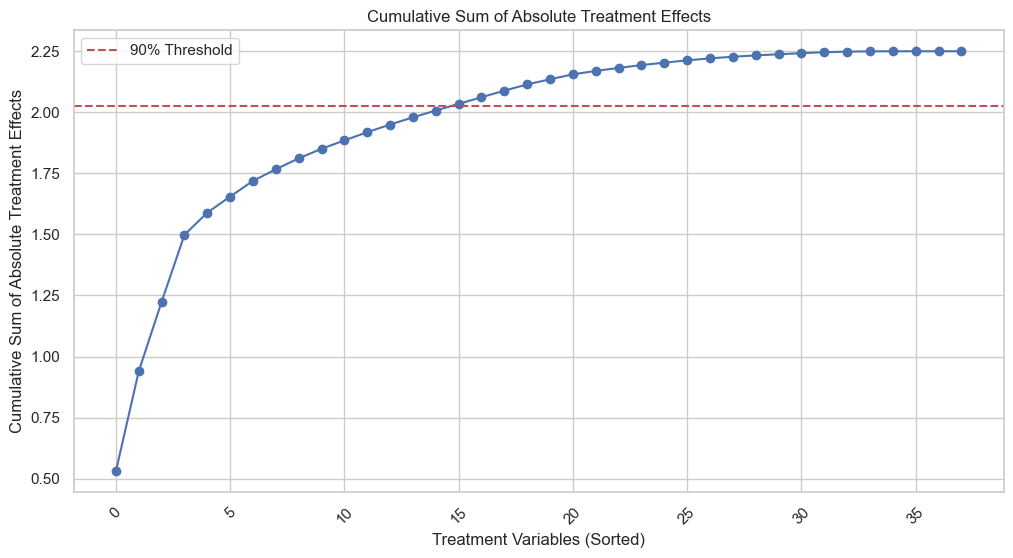

In [38]:
# Step 1: Calculate absolute values and sort them in descending order
sorted_effects = ete_df["Estimated Treatment Effect"].abs().sort_values(ascending=False)

# Step 2: Compute the cumulative sum
cumsum_effect = sorted_effects.cumsum()

# Step 3: Determine the 90% threshold of the total cumulative sum
threshold = 0.9 * cumsum_effect.iloc[-1]

# Step 4: Filter the rows that make up 90% of the cumulative sum
# Filter by index from the sorted list
filtered_ete_df = ete_df.loc[sorted_effects.index[cumsum_effect <= threshold]]

# Display the filtered DataFrame
display(filtered_ete_df)
print(filtered_ete_df.shape)

# Display the cumulative sum plot
plt.figure(figsize=(12, 6))
plt.plot(cumsum_effect.values, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Sum of Absolute Treatment Effects')
plt.xlabel('Treatment Variables (Sorted)')
plt.ylabel('Cumulative Sum of Absolute Treatment Effects')
plt.xticks(rotation=45)
plt.legend()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



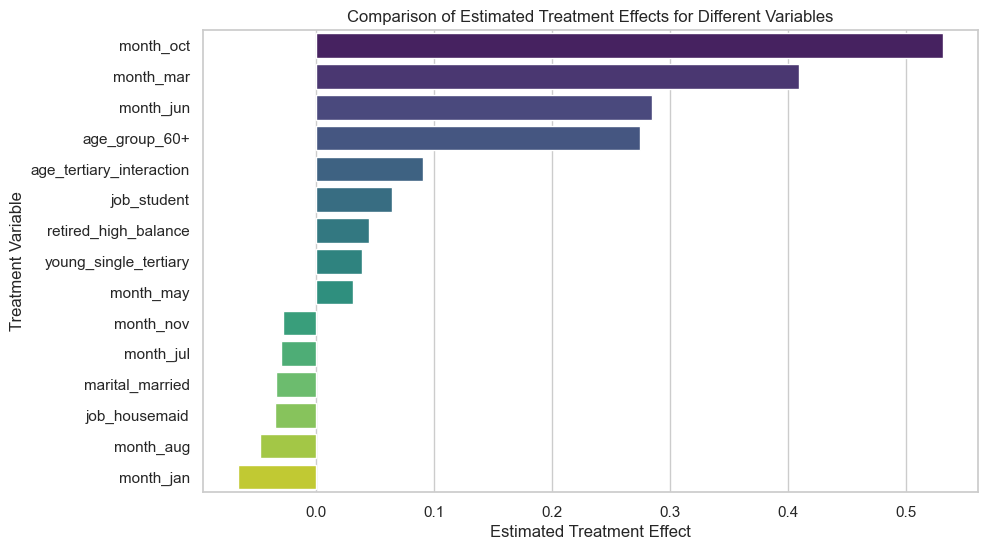

In [39]:
# Plotting the Estimated Treatment Effects
plt.figure(figsize=(10, 6))
sns.barplot(x='Estimated Treatment Effect', y='Treatment', data=filtered_ete_df.sort_values("Estimated Treatment Effect", ascending=False), palette='viridis')
plt.title('Comparison of Estimated Treatment Effects for Different Variables')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Treatment Variable')
plt.show()


### **Interpreting the Results**



#### 1. Identifying High-Impact Variables

- **Positive Effects**: 
  - **`month_oct (ETE = 0.531)`**: Being contacted in October has the highest positive effect on subscription likelihood, making it the most effective month for marketing efforts.
  - **`month_mar (ETE = 0.409)`**: March also shows a significant positive impact, indicating it's another good month for outreach.
  - **`age_group_60+ (ETE = 0.279)`**: Older individuals (60+) have a higher likelihood of subscribing, suggesting that age is an important factor in campaign targeting.
  - **`month_jun (ETE = 0.282)`**: June is another effective month for marketing, though slightly less impactful than March and October.
  - **`age_tertiary_interaction (ETE = 0.090)`**: The interaction between age and tertiary education has a smaller but still positive effect, suggesting that educated older individuals might be more receptive.
  - **`job_student (ETE = 0.061)`**: Students are also more likely to subscribe, indicating potential for targeted campaigns.

- **Negative Effects**:
  - **`month_jan (ETE = -0.066)`**: January is associated with a negative effect on subscription likelihood, suggesting it may not be an ideal time for marketing efforts.
  - **`month_aug (ETE = -0.047)`**: August shows a negative effect, indicating that outreach during this month may be less effective.
  - **`job_housemaid (ETE = -0.035)`**: Individuals working as housemaids are less likely to subscribe, suggesting this group may be less receptive to marketing efforts.
  - **`marital_married (ETE = -0.034)`**: Married individuals are slightly less likely to subscribe, indicating that marital status might influence financial decisions.

#### 2. Understanding Seasonal and Demographic Effects

- **Seasonality**: The months of October, March, and June show the strongest positive effects, while January and August have negative effects. This suggests a clear seasonality in customer behavior, where certain times of the year are more conducive to successful marketing efforts. October appears to be the peak month, which could be due to various factors like post-summer financial planning or end-of-year considerations.

- **Demographics**: 
  - **Age**: The `age_group_60+` variable shows that older individuals are more likely to subscribe, which could be due to their stable financial situation or a greater interest in secure investments like term deposits.
  - **Education**: The positive interaction between age and tertiary education further emphasizes that older, educated individuals are prime targets for these campaigns.
  - **Occupation**: The variable `job_student` suggests that students are more likely to subscribe, possibly because of their interest in saving or securing financial futures early on. In contrast, those in more labor-intensive jobs, such as housemaids, are less likely to subscribe, which might be due to different financial priorities or constraints.

#### 3. Actionable Insights

- **Timing Campaigns**: Focus marketing efforts on the months of October, March, and June. These months show the highest likelihood of success, so maximizing outreach during these times could yield better results.
- **Targeting Older Individuals**: Given the positive effect for the `age_group_60+`, tailoring messages or financial products specifically for older customers could increase subscription rates. This could involve emphasizing security, stability, and returns, which are likely to resonate with this demographic.
- **Adjusting for Marital Status and Occupation**: Since married individuals and those in certain occupations (like housemaids) show a lower likelihood of subscribing, consider adjusting the messaging or offerings for these groups, or focus resources on more responsive demographics.

#### 4. Mitigating Negative Effects

- **Avoiding Less Effective Months**: Minimize marketing efforts in January and August, or adjust strategies to counteract the lower effectiveness during these months.
- **Revising Strategies for Specific Demographics**: For groups like married individuals and housemaids, consider exploring alternative financial products or more tailored messaging that better aligns with their needs and financial situations.

In [40]:
# Define the treatment and outcome
treatment_var = 'high_balance'
outcome_var = 'y'

# Define the list of selected features for interaction analysis
selected_features = ['age_group_60+', 'education_tertiary', 'job_blue-collar', 
                     'job_student', 'loan_yes', 'housing_yes', 
                     'marital_married', 'education_secondary', 'default_yes']

# Initialize a dictionary to store the results
interaction_effects_dict = {}

# Loop through each feature in the selected_features list
for feature in tqdm(selected_features):
    # print(f"Running model with interaction: {feature}")
    
    # Create the interaction term by multiplying the treatment with the current feature
    interaction_term = data_encoded[treatment_var] * data_encoded[feature]
    
    # Create a new DataFrame that includes the interaction term
    features_with_interaction = data_encoded[selected_features].copy()
    features_with_interaction[f'{feature}_interaction'] = interaction_term
    
    # Define the Causal Forest model
    est = CausalForestDML(
        model_y=RandomForestRegressor(),
        model_t=RandomForestRegressor(),
        random_state=123
    )
    
    # Fit the model including the interaction term
    est.fit(
        Y=data_encoded[outcome_var], 
        T=data_encoded[treatment_var], 
        X=features_with_interaction
    )
    
    # Estimate the treatment effect with the interaction term
    treatment_effects = est.effect(features_with_interaction)
    
    # Store the mean interaction effect in the dictionary
    mean_interaction_effect = np.mean(treatment_effects)
    interaction_effects_dict[feature] = mean_interaction_effect

# Convert the dictionary to a DataFrame for easier interpretation
interaction_effects_df = pd.DataFrame(list(interaction_effects_dict.items()), columns=['Feature', 'Mean Interaction Effect'])

# Display the results
display(interaction_effects_df.sort_values("Mean Interaction Effect", ascending=False))

100%|██████████| 9/9 [00:30<00:00,  3.36s/it]


,Feature,Mean Interaction Effect
5,housing_yes,0.037990
4,loan_yes,0.031805
3,job_student,0.028171
0,age_group_60+,0.027664
2,job_blue-collar,0.026976
8,default_yes,0.026748
6,marital_married,0.024819
1,education_tertiary,0.017988
7,education_secondary,0.016273


In [41]:
from itertools import combinations

def calculate_unique_combinations(features):
    """
    Calculate all unique combinations of the features.
    
    Parameters:
    - features (list of str): The list of features to calculate combinations for.
    
    Returns:
    - list of tuples: Each tuple contains a unique pair of features.
    """
    return list(combinations(features, 2))


def estimate_interaction_effect(data, treatment_var, outcome_var, feature_pair):
    """
    Estimate the interaction effect between a treatment and a pair of features.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing all the relevant variables.
    - treatment_var (str): The name of the treatment variable.
    - outcome_var (str): The name of the outcome variable.
    - feature_pair (tuple of str): The pair of features to test for interaction.
    
    Returns:
    - float: The mean interaction effect for the given pair of features.
    """
    feature_1, feature_2 = feature_pair
    
    # Create interaction terms
    interaction_term = data[feature_1] * data[feature_2]
    
    # Create a new DataFrame that includes the interaction term
    features_with_interaction = data[[feature_1, feature_2]].copy()
    features_with_interaction[f'{feature_1}_{feature_2}_interaction'] = interaction_term
    
    # Define the Causal Forest model
    est = CausalForestDML(
        model_y=RandomForestRegressor(),
        model_t=RandomForestRegressor(),
        random_state=123
    )
    
    # Fit the model including the interaction term
    est.fit(
        Y=data[outcome_var], 
        T=data[treatment_var], 
        X=features_with_interaction
    )
    
    # Estimate the treatment effect with the interaction term
    treatment_effects = est.effect(features_with_interaction)
    
    # Return the mean interaction effect
    return np.mean(treatment_effects)


def run_all_combinations(data, treatment_var, outcome_var, features):
    """
    Run the interaction effect estimation for all unique combinations of features.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing all the relevant variables.
    - treatment_var (str): The name of the treatment variable.
    - outcome_var (str): The name of the outcome variable.
    - features (list of str): The list of features to calculate combinations for.
    
    Returns:
    - dict: A dictionary where the key is the feature pair and the value is the mean interaction effect.
    """
    # Calculate unique combinations
    unique_combinations = calculate_unique_combinations(features)
    
    # Initialize a dictionary to store results
    interaction_effects_dict = {}
    
    # Loop through each unique combination
    for feature_pair in unique_combinations:
        print(f"Running model with interaction: {feature_pair}")
        mean_interaction_effect = estimate_interaction_effect(data, treatment_var, outcome_var, feature_pair)
        interaction_effects_dict[feature_pair] = mean_interaction_effect
    
    return interaction_effects_dict

# Example usage:
selected_features = ['age_group_60+', 'education_tertiary', 'job_blue-collar', 
                     'job_student', 'loan_yes', 'housing_yes', 
                     'marital_married', 'education_secondary', 'default_yes']

# Run all combinations for the treatment 'high_balance'
interaction_results = run_all_combinations(
    data=data_encoded,
    treatment_var='high_balance',
    outcome_var='y',
    features=selected_features
)

# Convert to DataFrame for easy analysis
interaction_results_df = pd.DataFrame(list(interaction_results.items()), columns=['Feature Pair', 'Mean Interaction Effect'])
interaction_results_df.sort_values("Mean Interaction Effect", ascending=False)

Running model with interaction: ('age_group_60+', 'education_tertiary')
Running model with interaction: ('age_group_60+', 'job_blue-collar')
Running model with interaction: ('age_group_60+', 'job_student')
Running model with interaction: ('age_group_60+', 'loan_yes')
Running model with interaction: ('age_group_60+', 'housing_yes')
Running model with interaction: ('age_group_60+', 'marital_married')
Running model with interaction: ('age_group_60+', 'education_secondary')
Running model with interaction: ('age_group_60+', 'default_yes')
Running model with interaction: ('education_tertiary', 'job_blue-collar')
Running model with interaction: ('education_tertiary', 'job_student')
Running model with interaction: ('education_tertiary', 'loan_yes')
Running model with interaction: ('education_tertiary', 'housing_yes')
Running model with interaction: ('education_tertiary', 'marital_married')
Running model with interaction: ('education_tertiary', 'education_secondary')
Running model with interact

,Feature Pair,Mean Interaction Effect
30,"(housing_yes, marital_married)",0.033882
23,"(job_student, marital_married)",0.033744
18,"(job_blue-collar, marital_married)",0.033632
34,"(marital_married, default_yes)",0.033606
33,"(marital_married, education_secondary)",0.033000
22,"(job_student, housing_yes)",0.032573
15,"(job_blue-collar, job_student)",0.032551
25,"(job_student, default_yes)",0.032439
17,"(job_blue-collar, housing_yes)",0.032413
12,"(education_tertiary, marital_married)",0.032284


In [44]:
# Removing 'income' from the DAG
G = nx.DiGraph()

# Redefine the DAG without 'income'
G.add_edges_from([
    ("age_group_60+", "y"),
    ("month_oct", "y"),
    ("month_mar", "y"),
    ("month_jun", "y"),
    ("job_student", "y"),
    ("high_balance", "y"),
    ("education_tertiary", "high_balance"),
    ("education_tertiary", "y")
])

# Re-define the CausalModel
model = CausalModel(
    data_encoded,
    treatment='high_balance',  # Replace with the treatment variable you're focusing on
    outcome='y',
    graph=G
)

identified_estimand = model.identify_effect()
print(identified_estimand)


TypeError: CausalModel.__init__() got an unexpected keyword argument 'treatment'

In [45]:
# Example: Using 'month_oct' as the treatment variable
model = CausalModel(
    data=data_encoded,
    treatment='month_oct',
    outcome='y',
    graph=G  # Simplified graph without 'income'
)

identified_estimand = model.identify_effect()
print(identified_estimand)

# Estimate using Direct Adjustment if possible
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate: ", causal_estimate)

TypeError: CausalModel.__init__() got an unexpected keyword argument 'data'

In [48]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor

# Define and fit the Causal Forest model
est = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestRegressor(),
    random_state=123
)

X_features = data_encoded[['age_group_60+', 'month_oct', 'job_student', 'high_balance']]  # Adjust these features
T = data_encoded['high_balance']  # Treatment variable
Y = data_encoded['y']  # Outcome variable

# Ensure that the treatment has variance and is binary/continuous as expected
print(T.value_counts())

est.fit(Y=Y, T=T, X=X_features)

# Estimate the treatment effect
treatment_effect = est.effect(X_features)
print(f"Estimated Treatment Effect using Causal Forests: {np.mean(treatment_effect)}")

# Check confidence intervals
intervals = est.effect_interval(X_features)
print(f"95% Confidence Interval: {intervals}")

0    15785
1    10510
Name: high_balance, dtype: int64
Estimated Treatment Effect using Causal Forests: 0.0
95% Confidence Interval: (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))


## Export dataset

In [53]:
(data_encoded.drop(columns=['propensity_score', 'long_duration_bluecollar', 'long_duration_retired', 'duration_medium', 'duration_short', 'duration_long'])
            .to_parquet("../data/data_encoded.parquet", index=False))

In [52]:
(data_encoded.drop(columns=['propensity_score', 'long_duration_bluecollar', 'long_duration_retired', 'duration_medium', 'duration_short', 'duration_long'])
            .to_csv("../data/data_encoded.csv", index=False))